# 1. Global methane levels from 2002

## 1.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

#设置画图的默认字体为Times New Roman
plt.rcParams['font.family'] = 'serif'  
plt.rcParams['font.serif'] = ['Times New Roman']

#读取数据文件
#ds1 = xr.open_dataset('200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc')
ds1 = xr.open_dataset('200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc', engine='netcdf4')

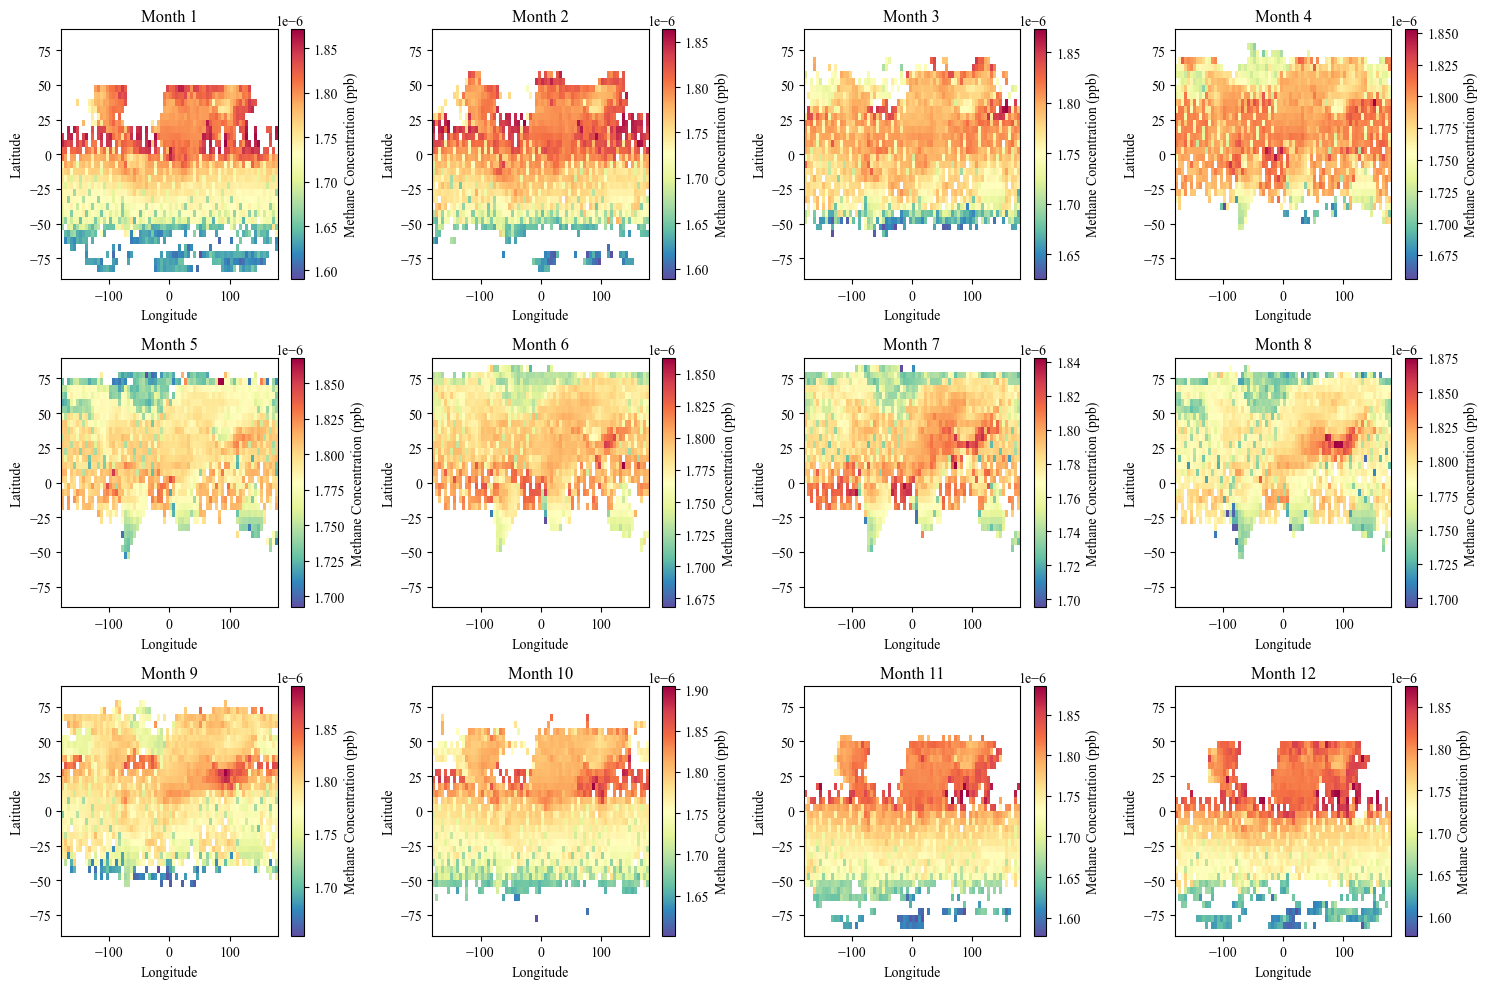

In [2]:
#计算甲烷数据每月气候态，先按月分组，然后求平均值
xch4_clim = ds1.xch4.groupby('time.month').mean(dim='time')

#绘图
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

#设置颜色条的字典，标题为Methane Concentration (ppm)，与色条的间隔为0.1
colorbar_kwargs = {
    "label": "Methane Concentration (ppb)",
    "pad": 0.05,
}

for i, month in enumerate(xch4_clim.month):
    ax = axes.flat[i]
    cbar = xch4_clim.sel(month=month).plot(ax=ax, cmap='Spectral_r', cbar_kwargs=colorbar_kwargs)
    cbar.set_label('Methane Concentration (ppm)')
    ax.set_title("Month %i"%month)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

## 1.2

Text(0, 0.5, 'CH4 (ppb)')

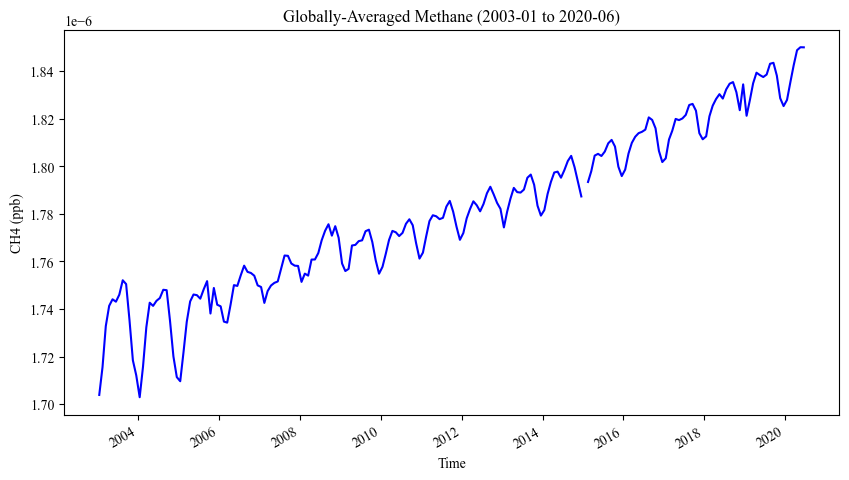

In [3]:
#对每天的甲烷数据进行全球范围内的空间平均
xch4_mean = ds1.xch4.mean(dim=['lat', 'lon'])

xch4_mean.plot(figsize=(10, 5), color='b')
#plt.plot(xch4_mean['time'], xch4_mean)
plt.title("Globally-Averaged Methane (2003-01 to 2020-06)")
plt.xlabel("Time")
plt.ylabel("CH4 (ppb)")

## 1.3

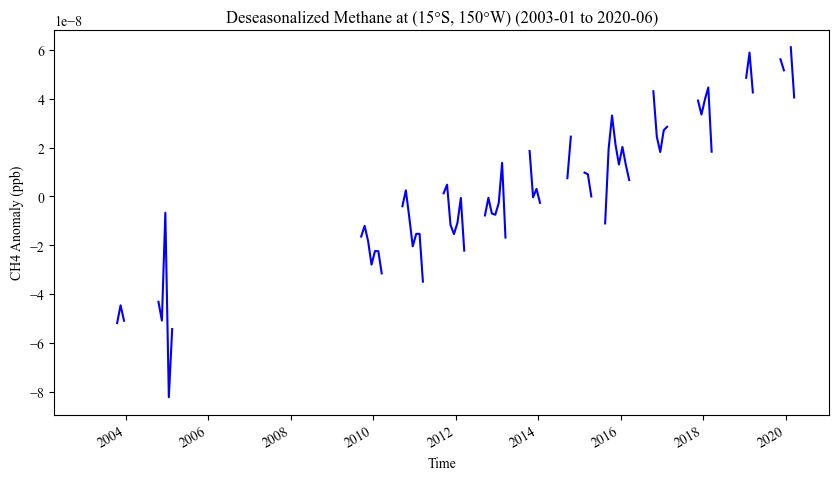

In [4]:
#提取出在15°S, 150°W点的2003-01到2020-06的甲烷数据
xch4_location = ds1.xch4.sel(lon=-150, lat=-15, method='nearest')

#按月分组，再减去月平均得出反季节甲烷水平异常时间序列数据
ch4_dss = xch4_location.groupby('time.month') - xch4_clim.sel(lon=-150, lat=-15, method='nearest')

ch4_dss.plot(figsize=(10, 5), color='b')
plt.title("Deseasonalized Methane at (15°S, 150°W) (2003-01 to 2020-06)")
plt.xlabel("Time")
plt.ylabel("CH4 Anomaly (ppb)")
plt.show()

可以看到从2003-01到2020-06，15°S, 150°W处的CH4异常呈现螺旋上升的趋势

# 2. Niño 3.4 index

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

ds2 = xr.open_dataset('NOAA_NCDC_ERSST_v3b_SST.nc', engine='netcdf4')
ds2.sst.sel(lat=slice(-5,5), lon=slice(10, 60))

<xarray.DataArray 'sst' (time: 684, lat: 5, lon: 26)>
[88920 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -4.0 -2.0 0.0 2.0 4.0
  * lon      (lon) float32 10.0 12.0 14.0 16.0 18.0 ... 52.0 54.0 56.0 58.0 60.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Attributes:
    pointwidth:          1.0
    valid_min:           -3.0
    valid_max:           45.0
    units:               degree_Celsius
    long_name:           Extended reconstructed sea surface temperature
    standard_name:       sea_surface_temperature
    iridl:hasSemantics:  iridl:SeaSurfaceTemperature

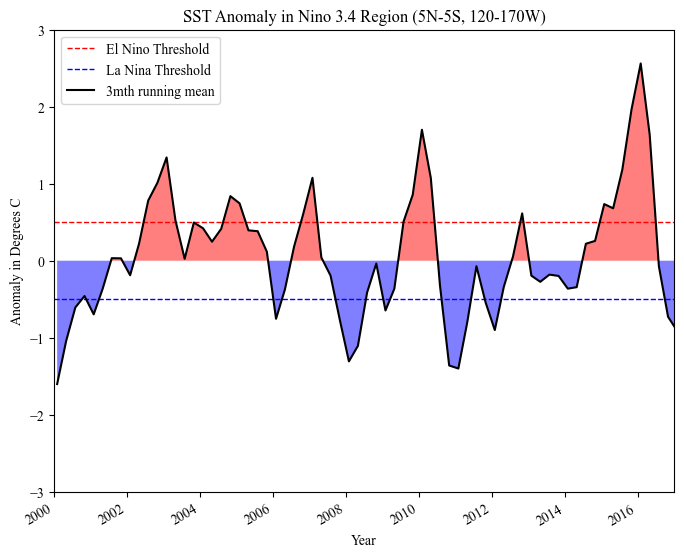

In [6]:
#提取3.4区域
nino34 = ds2.sel(lat=slice(-5,5), lon=slice(190, 240)).mean(dim=['lat', 'lon'])
#对3.4区域按月分组
nino34_mon = nino34.sst.groupby('time.month')
#计算3.4区域的月异常值
nino34_anom = nino34_mon - nino34_mon.mean(dim='time')
#计算3.4区域3个月的异常值
nino34_resample = nino34_anom.resample(time='3ME').mean(dim='time')
#提取2000到2020年的数据
nino34_resample_2000_2020 = nino34_resample.sel(time=slice('2000', '2020'))

#绘图
fig, ax = plt.subplots(figsize=(8, 6))

#绘制厄尔尼诺与拉尼娜的阈值直线
ax.axhline(y=0.5, color='r', linestyle='--', linewidth=1, label='El Nino Threshold')
ax.axhline(y=-0.5, color='b', linestyle='--', linewidth=1, label='La Nina Threshold')

#绘制异常值折线
nino34_resample_2000_2020.plot(ax=ax, color='k', label='3mth running mean')

#绘制填充区域
ax.fill_between(nino34_resample_2000_2020.time.values, nino34_resample_2000_2020.values, 
                0, where=nino34_resample_2000_2020.values >= 0, facecolor='red', interpolate=True, alpha=0.5)
ax.fill_between(nino34_resample_2000_2020.time.values, nino34_resample_2000_2020.values, 
                0, where=nino34_resample_2000_2020.values < 0, facecolor='blue', interpolate=True, alpha=0.5)

#设置图标题等
plt.title('SST Anomaly in Nino 3.4 Region (5N-5S, 120-170W)')
plt.xlabel('Year')
plt.ylabel('Anomaly in Degrees C')
plt.xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2016-12-31'))
plt.ylim(-3, 3)
ax.legend()

plt.show()

# 3. Explore a netCDF dataset

## 3.1

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.signal import detrend
import glob

#设置画图的默认字体为Times New Roman
plt.rcParams['font.family'] = 'serif'  
plt.rcParams['font.serif'] = ['Times New Roman']

#读取文件夹中的所有文件
#使用正则表达式获取output_file文件夹中所有符合条件的文件名
file_pattern = './output_file/oco2_GEOS_L3CO2_month_*_B10206Ar.nc4'
#使用glob.glob获取符合上述表达式的文件名，并对文件名进行排序
filenames = sorted(glob.glob(file_pattern))

#将所有数据都添加到一个列表中
datasets = []
for filename in filenames:
    ds_ = xr.open_dataset(filename, engine='netcdf4')
    datasets.append(ds_)

#将数据集合并
ds3 = xr.concat(datasets, dim='time')

#关闭数据集
for ds_ in datasets:
    ds_.close()

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.


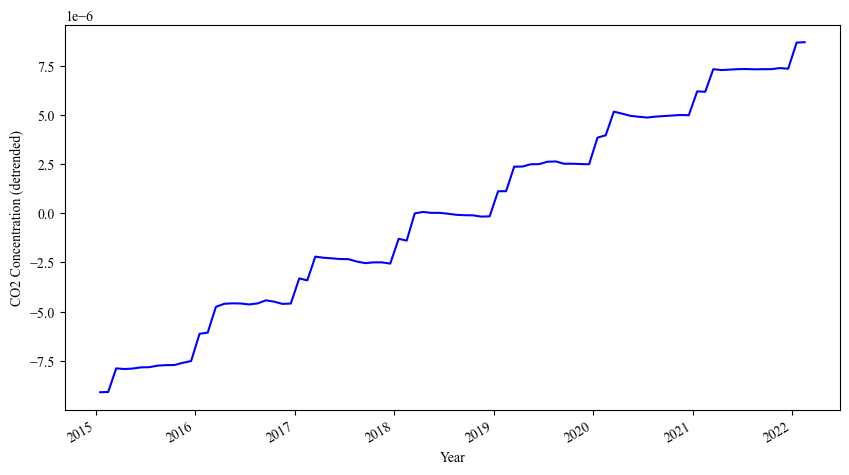

In [9]:
#对数据按月分组
XCO2_group = ds3.XCO2.groupby('time.month')
print(XCO2_group)
#计算数据CO2的气候态
XCO2_clim = XCO2_group.mean(dim='time')
#去除CO2数据的季节周期
XCO2_anom = XCO2_group - XCO2_clim
#XCO2_resample = XCO2_anom.resample(time="1ME")
#对每个时间的CO2数据进行全空间范围的均值
XCO2_mean = XCO2_anom.mean(dim=['lat', 'lon'])
#绘制2022年2月5日CO2全球范围均值在去除季节周期后的时间序列
XCO2_mean.plot(figsize=(10, 5), color='b')

plt.xlabel("Year")
plt.ylabel("CO2 Concentration (detrended)")
plt.show()

## 3.2

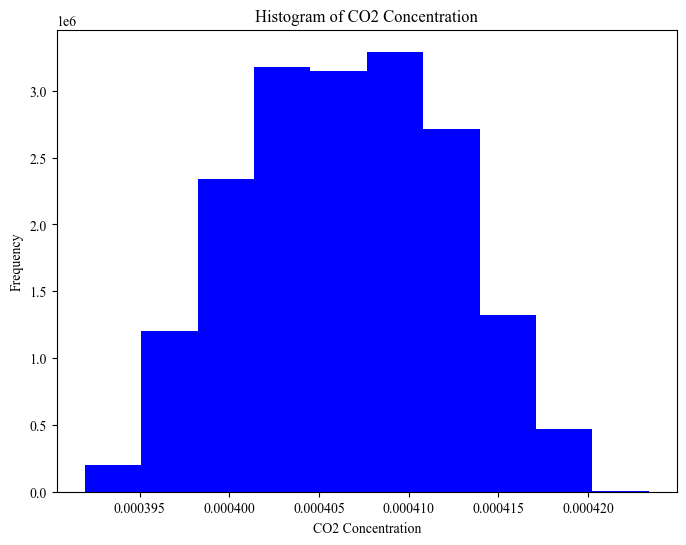

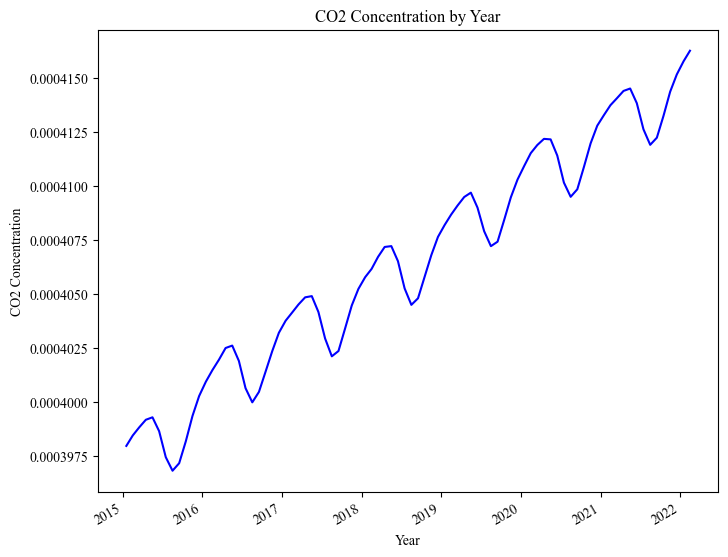

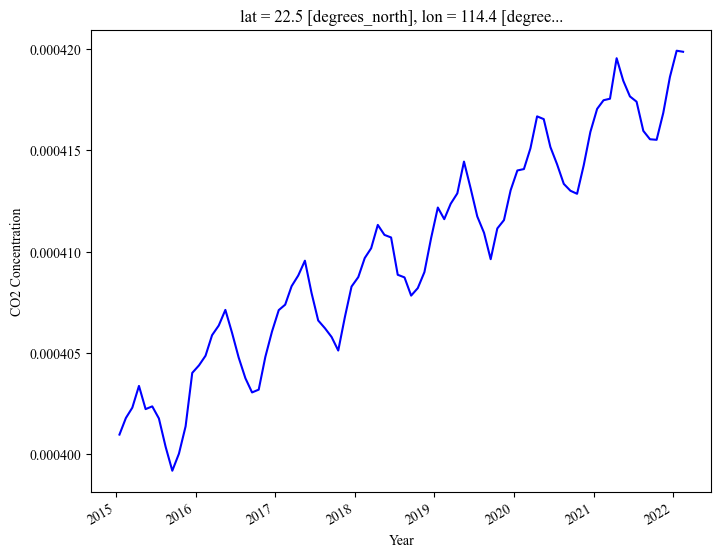

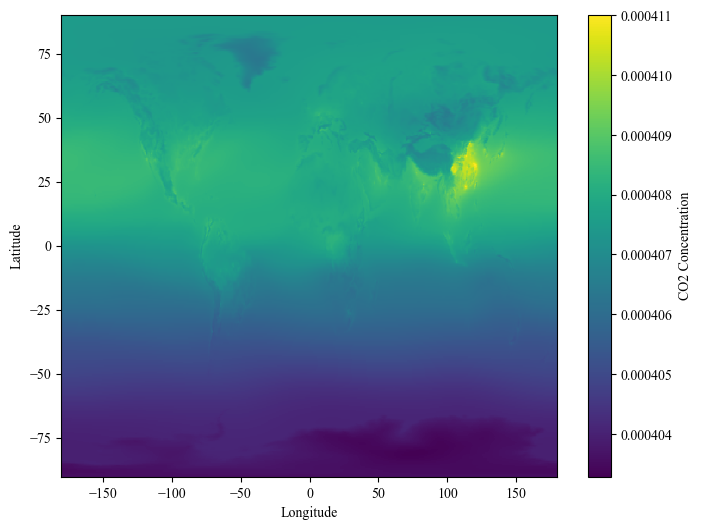

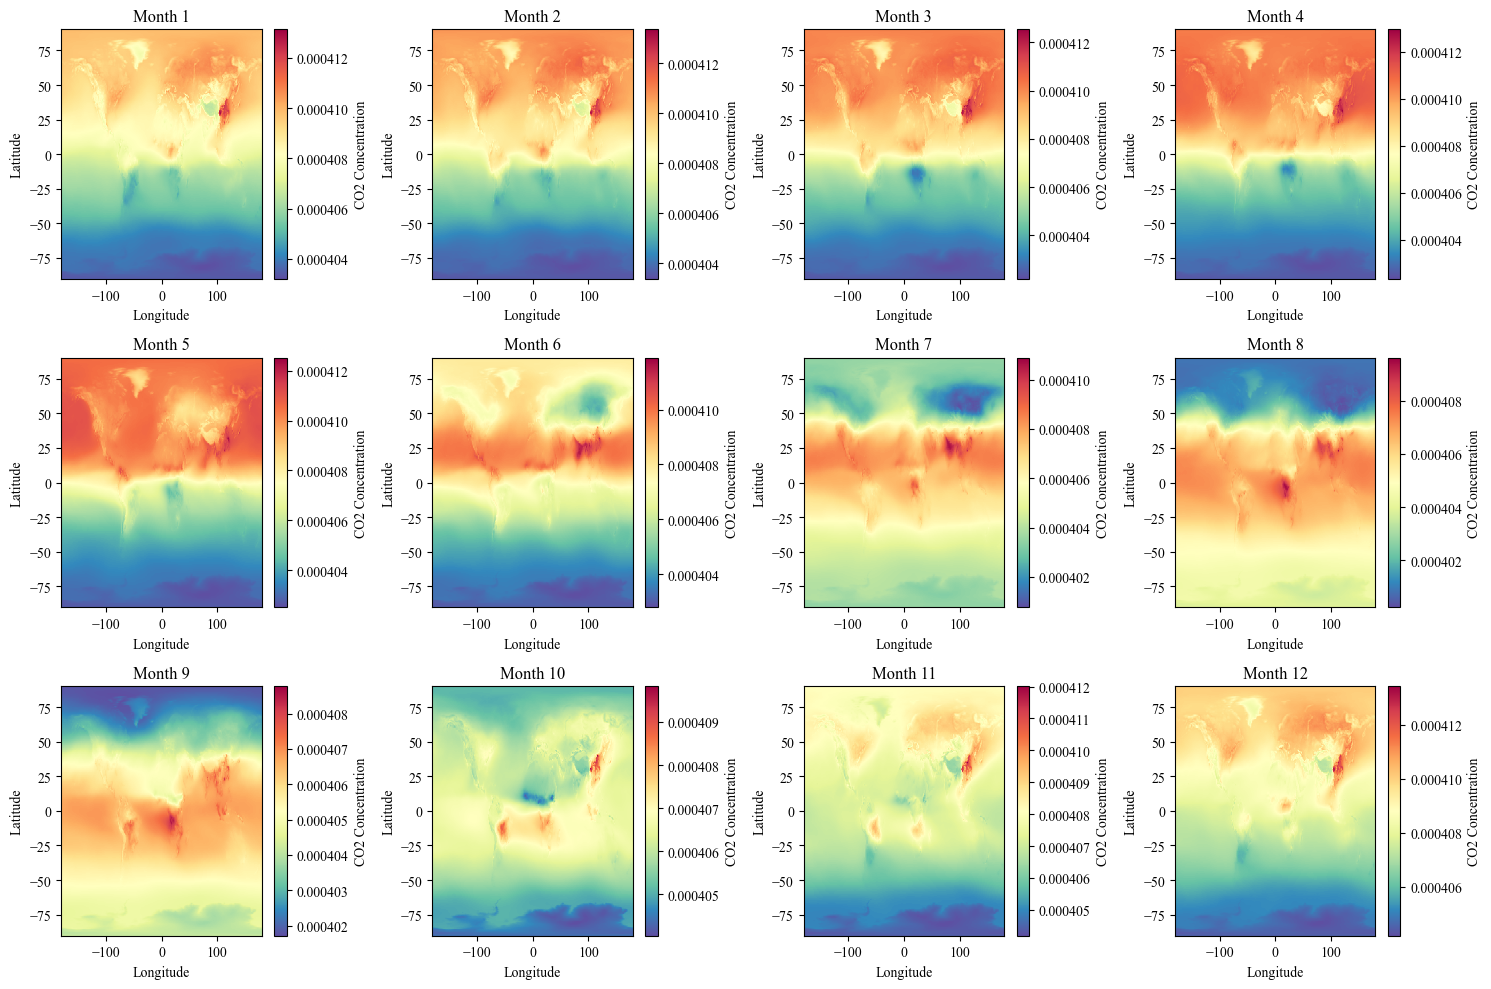

In [10]:
# 1. 直方图
plt.figure(figsize=(8, 6))
ds3.XCO2.plot(color='b')
plt.xlabel('CO2 Concentration')
plt.ylabel('Frequency')
plt.title('Histogram of CO2 Concentration')
plt.show()

# 2. 全球平均值年时间序列图
XCO2_year = ds3.XCO2.groupby('time.year').mean(dim=['lat', 'lon'])
plt.figure(figsize=(8, 6))
XCO2_year.plot(color='b')
plt.xlabel('Year')
plt.ylabel('CO2 Concentration')
plt.title('CO2 Concentration by Year')
plt.show()

# 3. 我所在地点时间序列图
plt.figure(figsize=(8, 6))
ds3.XCO2.sel(lon=114.1, lat=22.5, method='nearest').plot(color='b')
plt.xlabel('Year')
plt.ylabel('CO2 Concentration')
plt.show()

# 4. 全球浓度平均图
colorbar_kwargs = {
    "label": "CO2 Concentration",
    "pad": 0.05,
}
plt.figure(figsize=(8, 6))
ds3.XCO2.mean(dim='time').plot(cbar_kwargs=colorbar_kwargs)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# 5. 每月气候态全球图
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
#设置颜色条的字典，标题为Methane Concentration (ppm)，与色条的间隔为0.1
colorbar_kwargs = {
    "label": "CO2 Concentration",
    "pad": 0.05,
}
for i, month in enumerate(XCO2_clim.month):
    ax = axes.flat[i]
    cbar = XCO2_clim.sel(month=month).plot(ax=ax, cmap='Spectral_r', cbar_kwargs=colorbar_kwargs)
    cbar.set_label('CO2 Concentration')
    ax.set_title("Month %i"%month)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()